In [1]:
import numpy as np

# Gerar três números aleatórios a partir de uma distribuição gaussiana padrão
x = np.random.normal()
y = np.random.normal()
z = np.random.normal()

# Normalizar o vetor
norm = np.sqrt(x**2 + y**2 + z**2)
x /= norm
y /= norm
z /= norm

# Conversão para ângulos esféricos
theta = np.arccos(z)  # Colatitude
varphi = np.arctan2(y, x)  # Azimute

# Exibir os ângulos
print(f"theta = {theta}")
print(f"varphi = {varphi}")


theta = 2.5417436774926534
varphi = -3.1296913236069543


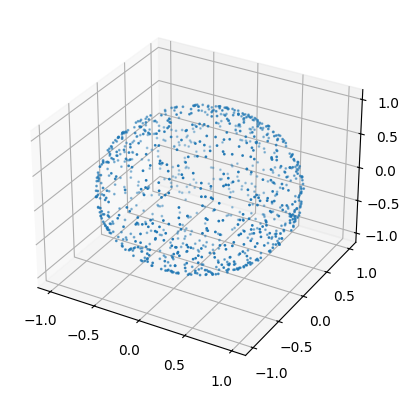

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gerar muitos pontos
num_points = 1000
points = []

for _ in range(num_points):
    x = np.random.normal()
    y = np.random.normal()
    z = np.random.normal()
    norm = np.sqrt(x**2 + y**2 + z**2)
    points.append((x/norm, y/norm, z/norm))

points = np.array(points)

# Plotar os pontos na esfera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1)

plt.show()


In [42]:
import numpy as np
import cvxpy as cp

def func_sorteioPOVM():
    # Passo 1: Gerar coordenadas x, y, z a partir de uma distribuição Gaussiana
    x = np.random.normal()
    y = np.random.normal()
    z = np.random.normal()
    
    # Passo 2: Normalizar o vetor (x, y, z)
    norm = np.sqrt(x**2 + y**2 + z**2)
    x /= norm
    y /= norm
    z /= norm
    
    # Passo 3: Converter para ângulos esféricos
    theta = np.arccos(z)  # [0, π]
    phi = np.arctan2(y, x)  # [-π, π]

    # Criando o POVM
    A = np.cos(theta/2)
    B = np.exp(1j*phi)*np.sin(theta/2)
    vetor_POVM =  np.array([A,B])
    vetor_POVM = vetor_POVM
    POVM = 2*np.outer(vetor_POVM, vetor_POVM.conj()) - np.eye(2)
    
    
    return POVM

def func_cpG(A0, A1, B0, B1, alpha):
    I = np.eye(2)
    G = alpha*cp.kron(A0,I) + cp.kron(A0, B0) + cp.kron(A1, B0) + cp.kron(A0, B1) - cp.kron(A1, B1)
    return G

def func_npG(A0, A1, B0, B1, alpha):
    I = np.eye(2)
    G = alpha*np.kron(A0,I) + np.kron(A0, B0) + np.kron(A1, B0) + np.kron(A0, B1) - np.kron(A1, B1)
    return G
    
def func_rho(G):
    # Obter os autovalores e autovetores da matriz G_CHSH
    eigenvalues, eigenvectors = np.linalg.eig(G)
    
    # Encontrar o índice do maior autovalor
    index = np.argmax(eigenvalues)
    
    # Obter o vetor associado ao maior autovalor
    psi = eigenvectors[:, index]
    
    # Normalizar o vetor
    psi_normalized = psi / np.linalg.norm(psi)
    
    # Calcular a matriz de densidade rho
    rho = np.outer(psi_normalized, psi_normalized.conj())

    return rho

def solve_sdpA(rho, A0, A1, B0, B1, alpha):
    A0_var = cp.Variable((2, 2), complex=True)
    A1_var = cp.Variable((2, 2), complex=True)
    I = np.eye(2)
    G = func_cpG(A0_var, A1_var, B0, B1, alpha)
    
    # Função objetivo
    objective = cp.Maximize(cp.real(cp.trace(rho @ G)))
    
    # Restrições
    constraints = [A0_var + I >> 0, A1_var + I >> 0, I - A0_var >> 0, I - A1_var >> 0, A0_var == A0_var.H, A1_var == A1_var.H]
    
    # Problema de otimização semidefinida
    problem = cp.Problem(objective, constraints)
    
    # Resolver o problema
    problem.solve(solver=cp.MOSEK)
    #print("Status do problema:", problem.status)
    
    # Retornar as matrizes A0 e A1
    return A0_var.value, A1_var.value

def solve_sdpB(rho, A0, A1, B0, B1, alpha):
    B0_var = cp.Variable((2, 2), complex=True)
    B1_var = cp.Variable((2, 2), complex=True)
    I = np.eye(2)
    G = func_cpG(A0, A1, B0_var, B1_var, alpha)
    
    # Função objetivo
    objective = cp.Maximize(cp.real(cp.trace(rho @ G)))

    # Restrições
    constraints = [B0_var + I >> 0, B1_var + I >> 0, I - B0_var >> 0, I - B1_var >> 0, B0_var == B0_var.H, B1_var == B1_var.H]
    
    # Problema de otimização semidefinida
    problem = cp.Problem(objective, constraints)
    
    # Resolver o problema
    problem.solve(solver=cp.MOSEK)
    #print("Status do problema:", problem.status)
    
    # Retornar as matrizes B0 e B1
    return B0_var.value, B1_var.value



def see_saw(alpha):    #Desigualdade CHSH inclinada
    # Sorteio POVMs (1)
    A0 = func_sorteioPOVM()
    A1 = func_sorteioPOVM()
    B0 = func_sorteioPOVM()
    B1 = func_sorteioPOVM()
    # Defina um critério de convergência
    tolerancia = 1e-6  # Defina a tolerância desejada para a convergência
    G = func_npG(A0, A1, B0, B1, alpha)
    rho = func_rho(G)

    # Inicialize uma variável para verificar se a convergência foi alcançada
    convergiu = False
    cotas = []
    i = 0
    cotas.append(np.real(np.trace(rho @ G)))

    while not convergiu:
        i +=1
        # Construa o observável G associada a desigualdade (2)
        I = np.eye(2)
        G = func_npG(A0, A1, B0, B1, alpha)
    
        # Matriz densidade a partir de G (3)
        rho = func_rho(G)
    
        #SDP A0, A1
        A0, A1 = solve_sdpA(rho, A0, A1, B0, B1, alpha)
        #SDP B0, B1
        B0, B1 = solve_sdpB(rho, A0, A1, B0, B1, alpha)

        #Teste a convergencia
        G = func_npG(A0, A1, B0, B1, alpha)
        rho = func_rho(G)
        cotas.append(np.real(np.trace(rho @ G)))
        if abs(cotas[i] - cotas[i-1]) < 1e-6:
            return alpha, cotas[i]
            
    



In [45]:
see_saw(0.5)


(0.5, 2.9154759284983762)

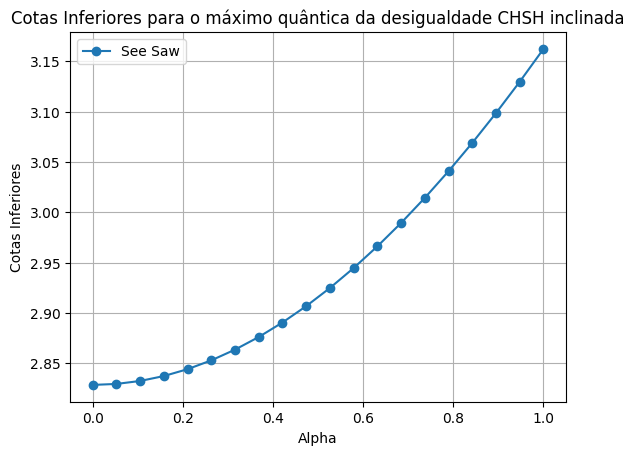

In [48]:
import matplotlib.pyplot as plt

# Listas para armazenar os valores
alpha_values = []
cota_values = []

for alpha in np.linspace(0, 1, 20):
    alpha_opt, y_opt = see_saw(alpha)
    alpha_values.append(alpha_opt)
    cota_values.append(y_opt)
    


plt.plot(alpha_values, cota_values, marker='o', linestyle='-', label="See Saw")
plt.xlabel('Alpha')
plt.ylabel('Cotas Inferiores')
plt.title('Cotas Inferiores para o máximo quântica da desigualdade CHSH inclinada')


plt.grid(True)
plt.legend()
plt.savefig('grafico.png')
plt.show()

In [61]:
def func_cpG2(A0, A1, A2, B0, B1, B2):
    I = np.eye(2)
    G = (-cp.kron((A0+A1+B0+B1),I) - cp.kron(A0,B0) - cp.kron(A1,B0) - cp.kron(A2,B0) - cp.kron(A0,B1) 
         - cp.kron(A1,B1) + cp.kron(A2,B1) - cp.kron(A0,B2) + cp.kron(A1,B2))
    return G

def func_npG2(A0, A1, A2, B0, B1, B2):
    I = np.eye(2)
    G = (-np.kron((A0+A1+B0+B1),I) - np.kron(A0,B0) - np.kron(A1,B0) - np.kron(A2,B0) - np.kron(A0,B1) 
         - np.kron(A1,B1) + np.kron(A2,B1) - np.kron(A0,B2) + np.kron(A1,B2))
    return G

def solve_sdpA2(rho, A0, A1, A2, B0, B1, B2):
    A0_var = cp.Variable((2, 2), complex=True)
    A1_var = cp.Variable((2, 2), complex=True)
    A2_var = cp.Variable((2, 2), complex=True)
    I = np.eye(2)
    G = func_cpG2(A0_var, A1_var, A2_var, B0, B1, B2)
    
    # Função objetivo
    objective = cp.Maximize(cp.real(cp.trace(rho @ G)))
    
    # Restrições
    constraints = [A0_var + I >> 0, A1_var + I >> 0, A2_var + I >> 0, I - A0_var >> 0, I - A1_var >> 0, I - A2_var >> 0, A0_var == A0_var.H, A1_var == A1_var.H,  A2_var == A2_var.H]
    
    # Problema de otimização semidefinida
    problem = cp.Problem(objective, constraints)
    
    # Resolver o problema
    problem.solve(cp.MOSEK)
    
    # Retornar as matrizes A0, A1 e A2
    return A0_var.value, A1_var.value, A2_var.value

def solve_sdpB2(rho, A0, A1, A2, B0, B1, B2):
    B0_var = cp.Variable((2, 2), complex=True)
    B1_var = cp.Variable((2, 2), complex=True)
    B2_var = cp.Variable((2, 2), complex=True)
    I = np.eye(2)
    G = func_cpG2(A0, A1, A2, B0_var, B1_var, B2_var)
    
    # Função objetivo
    objective = cp.Maximize(cp.real(cp.trace(rho @ G)))
    
    # Restrições
    constraints = [B0_var + I >> 0, B1_var + I >> 0, B2_var + I >> 0, I - B0_var >> 0, I - B1_var >> 0, I - B2_var >> 0, B0_var == B0_var.H, B1_var == B1_var.H,  B2_var == B2_var.H]
    
    # Problema de otimização semidefinida
    problem = cp.Problem(objective, constraints)
    
    # Resolver o problema
    problem.solve(cp.MOSEK)
    
    # Retornar as matrizes B0, B1 e B2
    return B0_var.value, B1_var.value, B2_var.value


def see_saw2():    #Desigualdade I3322
    # Sorteio POVMs (1)
    A0 = func_sorteioPOVM()
    A1 = func_sorteioPOVM()
    A2 = func_sorteioPOVM()
    B0 = func_sorteioPOVM()
    B1 = func_sorteioPOVM()
    B2 = func_sorteioPOVM()
    # Defina um critério de convergência
    tolerancia = 1e-6  # Defina a tolerância desejada para a convergência
    G = func_npG2(A0, A1, A2, B0, B1, B2)
    rho = func_rho(G)

    # Inicialize uma variável para verificar se a convergência foi alcançada
    convergiu = False
    cotas = []
    i = 0
    cotas.append(np.real(np.trace(rho @ G)))

    while not convergiu:
        i +=1
        # Construa o observável G associada a desigualdade (2)
        I = np.eye(2)
        G = func_npG2(A0, A1, A2, B0, B1, B2)
    
        # Matriz densidade a partir de G (3)
        rho = func_rho(G)
    
        #SDP A0, A1
        A0, A1, A2 = solve_sdpA2(rho, A0, A1, A2, B0, B1, B2)
        #SDP B0, B1
        B0, B1, B2 = solve_sdpB2(rho, A0, A1, A2, B0, B1, B2)

        #Teste a convergencia
        G = func_npG2(A0, A1, A2, B0, B1, B2)
        rho = func_rho(G)
        cotas.append(np.real(np.trace(rho @ G)))
        if abs(cotas[i] - cotas[i-1]) < 1e-6:
            return i, cotas[i]

In [62]:
see_saw2()

(13, 7.999999909736633)